# Target Model Training for Poisoning Attack Demonstration

This notebook demonstrates how to train a target model that we will later attack using various Poisoning attack techniques as described in the Security and Privacy of AI Knowledge Guide.

We will use the MNIST dataset, which is simpler and trains faster while still providing a good example for demonstrating Poisoning attacks.

We will:
1. Load the MNIST dataset
2. Prepare the data
3. Build a simple CNN model
4. Train the model
5. Evaluate the model's performance
6. Save the model for later deployment

## 1. Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pickle
import os

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-04-15 11:18:24.281013: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 11:18:24.806839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744712304.986534    5265 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744712305.038743    5265 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744712305.427867    5265 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## 2. Load and prepare MNIST dataset

MNIST is a dataset of 28x28 grayscale images of handwritten digits (0-9). It's simple, trains quickly, and is perfect for our demonstration.

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Print dataset shapes
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


### Visualize some examples from the dataset

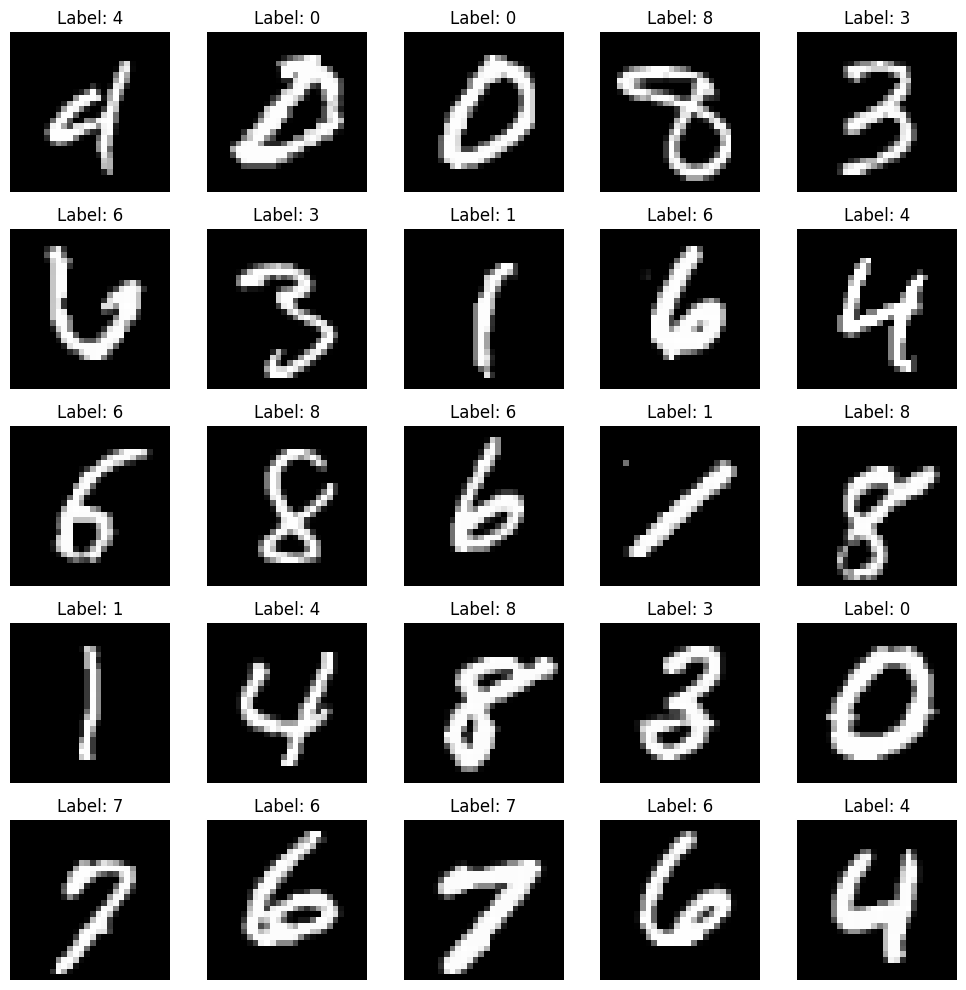

In [3]:
# Show random sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    idx = np.random.randint(0, len(x_train))
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Preprocess the data

In [4]:
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to include channel dimension (MNIST is grayscale, so 1 channel)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert class vectors to binary class matrices (one-hot encoding)
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("Data preprocessing completed.")

Data preprocessing completed.


## 3. Build a CNN model

We'll create a simple convolutional neural network for digit classification.

In [5]:
def build_model():
    model = Sequential([
        # First convolutional layer
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        
        # Second convolutional layer
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    
    return model

# Create model
model = build_model()

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Display model summary
model.summary()

/home/cybok/Desktop/cybok/cybokenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-15 11:19:38.973546: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the model

MNIST is simple enough that we don't need data augmentation or complex training procedures.

In [6]:
# Create a directory for model checkpoints
if not os.path.exists('model_checkpoints'):
    os.makedirs('model_checkpoints')

# Callback for model checkpointing
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoints/mnist_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [7]:
# Train the model
batch_size = 128
epochs = 10

history = model.fit(
    x_train, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test_cat),
    callbacks=[checkpoint]
)

Epoch 1/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8491 - loss: 0.5072 
Epoch 1: val_accuracy improved from -inf to 0.98160, saving model to model_checkpoints/mnist_model_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.8495 - loss: 0.5060 - val_accuracy: 0.9816 - val_loss: 0.0582
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9776 - loss: 0.0711 
Epoch 2: val_accuracy improved from 0.98160 to 0.98670, saving model to model_checkpoints/mnist_model_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.9776 - loss: 0.0711 - val_accuracy: 0.9867 - val_loss: 0.0406
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9855 - loss: 0.0468 
Epoch 3: val_accuracy improved from 0.98670 to 0.98750, saving model to model_checkpoints/mnist_model_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.9855 - loss: 0.0468 - val_accuracy: 0.9875 - val_loss: 0.0360
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9887 - loss: 0.0376 
Epoch 4: val_accuracy improved from 0.98750 to 0.98790, saving model to model_checkpoints/mnist_model_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9887 - loss: 0.0376 - val_accuracy: 0.9879 - val_loss: 0.0363
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9914 - loss: 0.0289 
Epoch 5: val_accuracy improved from 0.98790 to 0.98950, saving model to model_checkpoints/mnist_model_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.9914 - loss: 0.0289 - val_accuracy: 0.9895 - val_loss: 0.0312
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9922 - loss: 0.0250 
Epoch 6: val_accuracy improved from 0.98950 to 0.98990, saving model to model_checkpoints/mnist_model_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.9922 - loss: 0.0250 - val_accuracy: 0.9899 - val_loss: 0.0303
Epoch 7/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9930 - loss: 0.0200 
Epoch 7: val_accuracy improved from 0.98990 to 0.99100, saving model to model_checkpoints/mnist_model_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9930 - loss: 0.0200 - val_accuracy: 0.9910 - val_loss: 0.0284
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9940 - loss: 0.0180 
Epoch 8: val_accuracy improved from 0.99100 to 0.99180, saving model to model_checkpoints/mnist_model_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.9940 - loss: 0.0180 - val_accuracy: 0.9918 - val_loss: 0.0253
Epoch 9/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9956 - loss: 0.0141 
Epoch 9: val_accuracy did not improve from 0.99180
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.9956 - loss: 0.0141 - val_accuracy: 0.9917 - val_loss: 0.0273
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9955 - loss: 0.0128 
Epoch 10: val_accuracy did not improve from 0.99180
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9955 - loss: 0.0128 - val_accuracy: 0.9909 - val_loss: 0.0286


## 5. Evaluate model performance

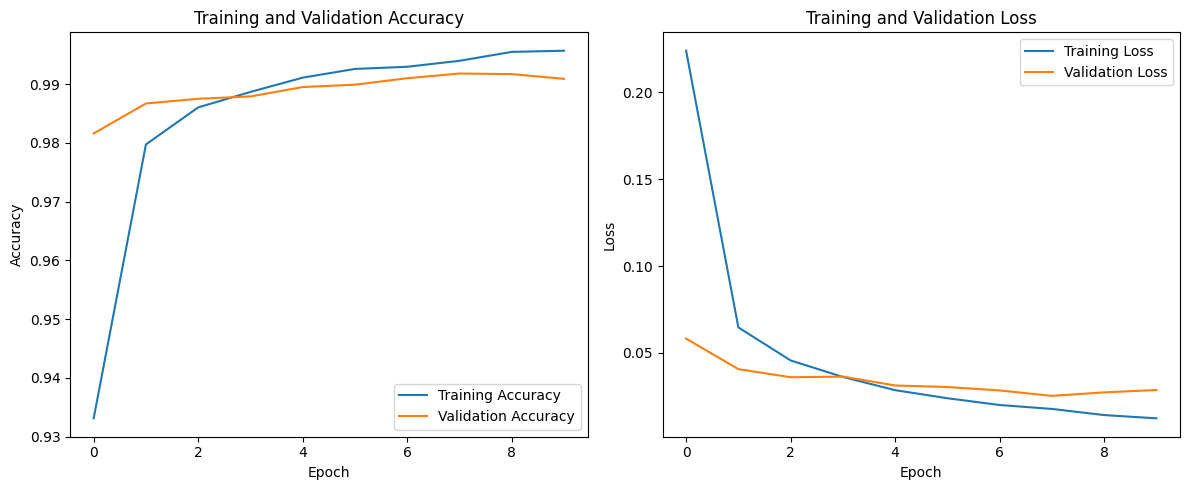

In [8]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [9]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test_cat, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9881 - loss: 0.0363
Test Loss: 0.0286
Test Accuracy: 0.9909


### Confusion Matrix and Classification Report

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


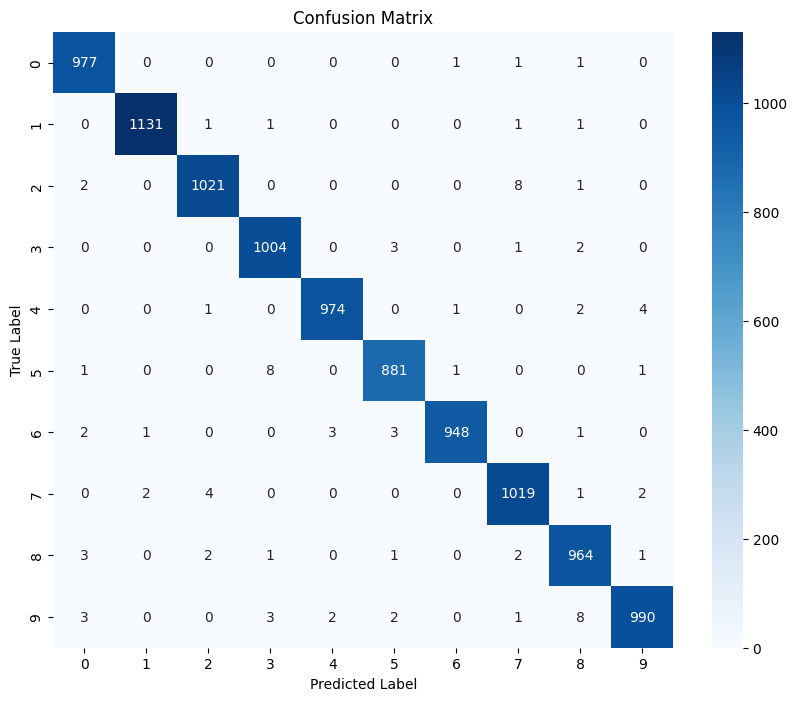

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [10]:
# Predict on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

### Analyze misclassified images

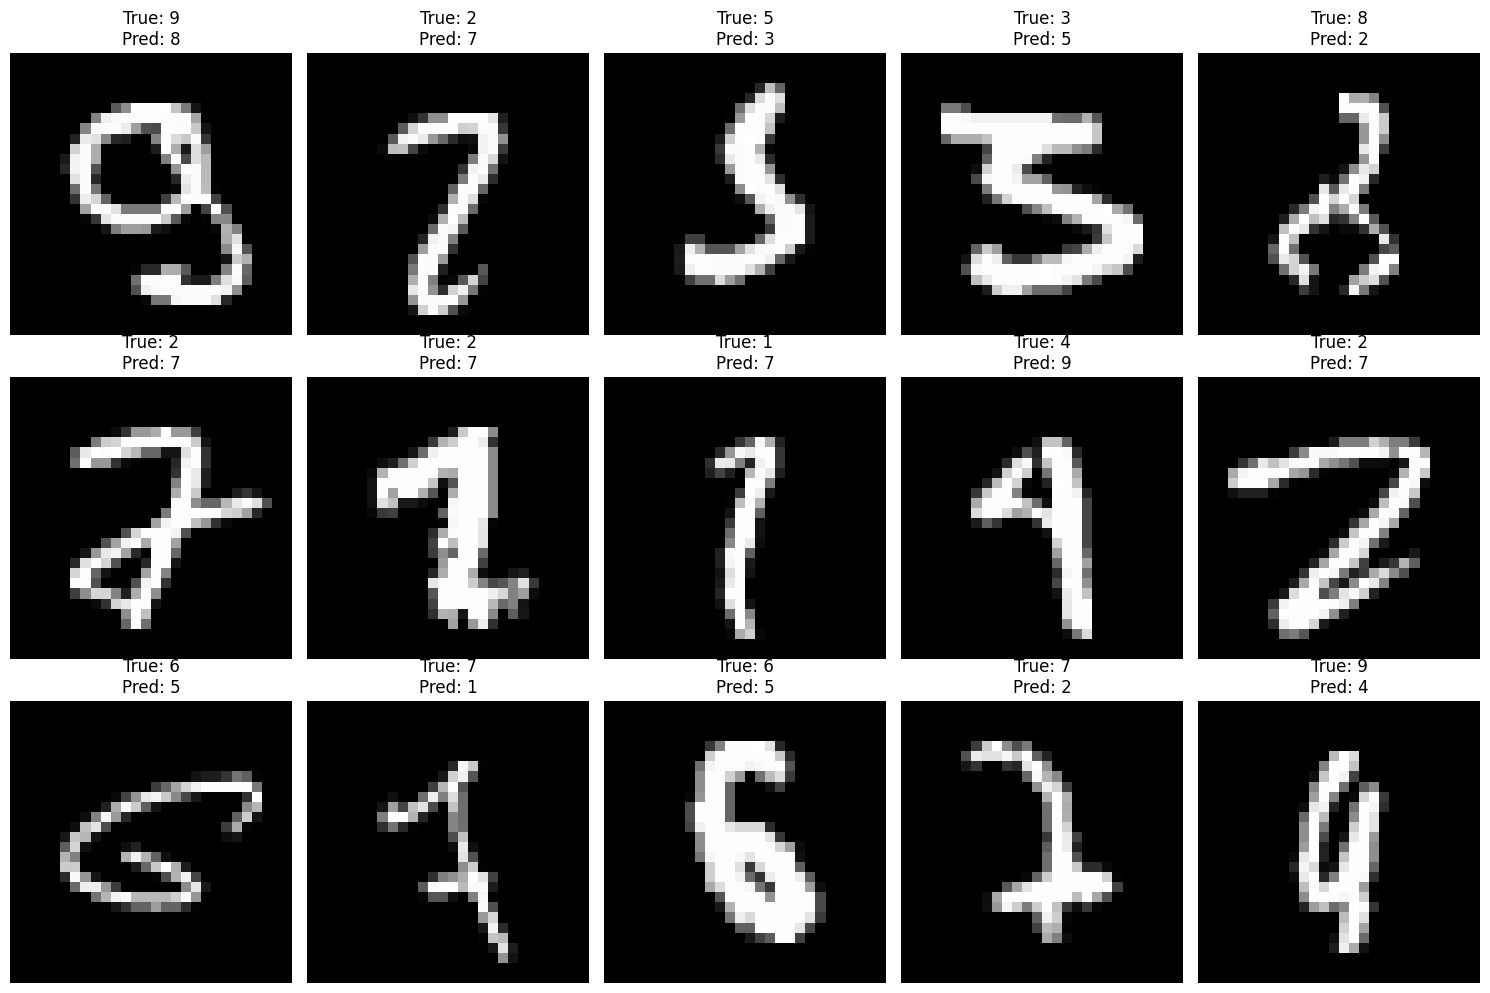

In [11]:
# Find indices of misclassified images
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Show some misclassified images
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:15]):
    plt.subplot(3, 5, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_true[idx]}\nPred: {y_pred_classes[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 6. Save the model for deployment

In [13]:
# Create a directory for the final model if it doesn't exist
if not os.path.exists('saved_model'):
    os.makedirs('saved_model')

# Save the model in two formats
# 1. TensorFlow SavedModel format (for TF Serving)
model.save('models/mnist_cnn_model.keras')
print("Model saved in TensorFlow SavedModel format.")

# 2. HDF5 format (for easier loading in various environments)
model.save('models/mnist_cnn_model.h5')
print("Model saved in HDF5 format.")

# Define class names (MNIST digits 0-9)
class_names = [str(i) for i in range(10)]

# Save model information for future reference
model_info = {
    'input_shape': (28, 28, 1),
    'class_names': class_names,
    'test_accuracy': test_accuracy,
    'preprocessing': 'normalize between 0 and 1'
}

with open('models/model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("Model information saved.")

Model saved in TensorFlow SavedModel format.
Model saved in HDF5 format.
Model information saved.


## Conclusion

We have successfully:
1. Loaded and prepared the MNIST dataset
2. Built a simple CNN model for digit classification
3. Trained the model
4. Evaluated the model's performance
5. Saved the model for deployment

In the next steps, we will deploy this model using Flask and then create attack notebooks to demonstrate how Poisoning attacks can be performed against this target model.